In [2]:
import pandas as pd
import numpy as np
import datetime
import itertools
from numba import njit
import csv
import pickle


## User imports the datasets

In [3]:
def txt2time(txt_time):

    """
    Converts string to Timestamp
    Input: Sequence of times ("Y-m-d H:M:S") in text
    """
    timeseq = [datetime.datetime.strptime(s,"%Y-%m-%d %H:%M:%S") for s in txt_time]
    return  timeseq

In [4]:
#Hospital data: December 7, 2010
Hospitaldata = pd.read_csv("/Volumes/G-DRIVE/codetest/Hospitaldata.csv")
Hospitaldata["id"] = txt2time(Hospitaldata["id"])
Hospitalseq = Hospitaldata.values

In [5]:
#Workplace data: June 27, 2015 PICKUP HERE
Workplacedata = pd.read_csv("/Volumes/G-DRIVE/codetest/Workplacedata.csv")
Workplacedata["id"] = txt2time(Workplacedata["id"])
Workplaceseq = Workplacedata.values

In [6]:
#International Conference on Computational Science data: July 11, 2017
IC17data = pd.read_csv("/Volumes/G-DRIVE/codetest/IC2S2data.csv")
IC17data["id"] = txt2time(IC17data["id"])
IC17seq = IC17data.values

In [7]:
#Winter School data: December 1, 2016
WS16data = pd.read_csv("/Volumes/G-DRIVE/codetest/WS16data.csv")
WS16data["id"] = txt2time(WS16data["id"])
WS16seq = WS16data.values

#### Parameter combinations used to obatin the estimates for all, except Workplace

In [8]:
#1 User imports the Dictionary of parameter combinations. Format - ID: (kappa, Np)
parcombs = pd.read_csv('/Volumes/G-DRIVE/codetest/paramcombs.csv')
parcombs_dict = parcombs.set_index("id").T.to_dict("list")
parcombs2 = {key:tuple(values) for key, values in parcombs_dict.items()}

In [10]:
#2 User imports the likelihood functions
Likelihoodfns = {}
for combs in parcombs2:
    df = pd.read_pickle("/Volumes/G-DRIVE/Densifcation_Olap_data/likelihoodfns_prob1k025/Likefn"+combs)
    Likelihoodfns[combs] = df[["N","M","prob"]].values



#### Workplace data

- Workplace dataset has smaller gridsize for some parameters

In [17]:
#1 User imports the Dictionary of parameter combinations. Format - ID: (kappa, Np)
parcombs_workplace = pd.read_csv('/Volumes/G-DRIVE/codetest/paramcombs_workplace.csv')
parcombs_workplace_dict = parcombs_workplace.set_index("id").T.to_dict("list")
parcombs_workplace2 = {key:tuple(values) for key, values in parcombs_workplace_dict.items()}

In [18]:
#User imports the likelihood functions for the Workplace dataset
Likelihoodfns_workplace = {}
for combs in parcombs_workplace2:
    df = pd.read_pickle("/Volumes/G-DRIVE/Densifcation_Olap_data/likelihoodfns_prob1k01_wkpl15/Likefn"+combs)
    Likelihoodfns_workplace[combs] = df[["N","M","prob"]].values



## Implement the maximum-likelihood estimation

### Helper function (Nested in MLEstimation) selecting the maximum-likelihood function

In [21]:
@njit()
def prob_func(A,E,likelihood):
    
    """
        A - active banks (type:float)
        E - number of undirected edges (type:float)
        likelihood - likelihood function given a kappa and Np,
        (type: B x 3 numpy array, where B is the number combinations of N,M generated from 
        kappa and Np)
        Returns the probability of observing A and E given a kappa and Np.
    """
    
    probindex = np.where((likelihood[0:,0]==A) & (likelihood[0:,1]==E))
    if probindex[0].size!=0:
        probability = likelihood[probindex][0,-1]
    
    return probability

### Helper function (Nested in MLEstimation) matching ids for mles with actual kappa and np values

In [13]:
def estimators(estimates, params):
    """
    Input: Sequences of IDs for (kappa, Np) combinations which have been
    identified as estimators by the method.
    
    Output: DataFrame of estimates kappa_hat and Np_hat given a time window t
    
    The function matches the ids of the parameter combination with the ML
    estimators (kappa_hat and Np_hat).
    """
    kappa_seq = []
    np_seq = []
    for combs in estimates["params"]:
        kappa,np = params[combs]
        kappa_seq.append(kappa)
        np_seq.append(np)
    return kappa_seq,np_seq
    

## Maximum-likelihood estimation function

In [14]:

def MLEstimation(NMseq,likelihood_funcs,params):
    """
    Input.
    
    NMseq: Sequence of triplets consisting of time (t), total active nodes (N) and total edges (M).
    likelihood_funcs: Sequence of joint prob. dists. Dict type i.e., parameter combination id: joint prob dist
    params: Sequence of parameter combinations. Dict type i.e., parameter id: (kappa, Np)
    
    Output. 
    estimates: Estimates of overall activity and population size. Type: (pandas.DataFrame)
    """
    knp_ests = []
    timeseq = []
    for elem in NMseq:
        t,N,M = elem
        prob_NM = []
        combid = []
        for fid,LF in likelihood_funcs.items():
            prob_NM.append(prob_func(N,M,LF))
            combid.append(fid)
        estparam_index = np.argmax(np.asarray(prob_NM))
        estparams_id = combid[estparam_index]
        knp_ests.append( estparams_id)
        timeseq.append(t)
        MLEresults = dict(zip(timeseq,knp_ests))
    #
    estimates = pd.DataFrame.from_dict(MLEresults,orient = "index")
    estimates.reset_index(drop = False, inplace = True)
    estimates.rename(columns = {"index":"t",0:"params"}, inplace = True)
    kappavalues, npvalues = estimators(estimates,params)
    estimates["kappa"] = kappavalues
    estimates["np"] = npvalues
    return estimates

## Result: Estimated activity and population size for the datasets

In [26]:
Hospitaldailyestimates = MLEstimation(Hospitalseq,Likelihoodfns,parcombs2)
IC17dailyestimates = MLEstimation(IC17seq,Likelihoodfns,parcombs2)
WSdailyestimates = MLEstimation(WS16seq,Likelihoodfns,parcombs2)

In [27]:
Workplacedailyestimates = MLEstimation(Workplaceseq,Likelihoodfns_workplace,parcombs_workplace2)

In [38]:
Hospitaldailyestimates.head()

,t,params,kappa,np
0,2010-12-07 00:08:00,p36182,3.95,2.0
1,2010-12-07 00:13:00,p0,0.00,2.0
2,2010-12-07 00:18:00,p0,0.00,2.0
3,2010-12-07 00:23:00,p0,0.00,2.0
4,2010-12-07 00:28:00,p36182,3.95,2.0


In [64]:
Workplacedailyestimates.head()

,t,params,kappa,np
0,2015-06-27 08:00:20,p9685,0.75,12.0
1,2015-06-27 08:05:20,p9685,0.75,12.0
2,2015-06-27 08:10:20,p9685,0.75,12.0
3,2015-06-27 08:15:20,p9685,0.75,12.0
4,2015-06-27 08:20:20,p9685,0.75,12.0


In [30]:
IC17seqdailyestimates.head()

,t,params,kappa,np
0,2017-07-11 08:00:40,p36182,3.950,2.0
1,2017-07-11 08:05:40,p36415,3.975,6.0
2,2017-07-11 08:10:40,p35271,3.850,7.0
3,2017-07-11 08:15:40,p36644,4.000,6.0
4,2017-07-11 08:20:40,p28630,3.125,7.0


In [31]:
WSdailyestimates.head()

,t,params,kappa,np
0,2016-12-01 07:49:40,p28630,3.125,7.0
1,2016-12-01 07:54:40,p35958,3.925,7.0
2,2016-12-01 07:59:40,p35958,3.925,7.0
3,2016-12-01 08:04:40,p36418,3.975,9.0
4,2016-12-01 08:09:40,p36189,3.950,9.0


## Plots:

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

### Estimated kappa

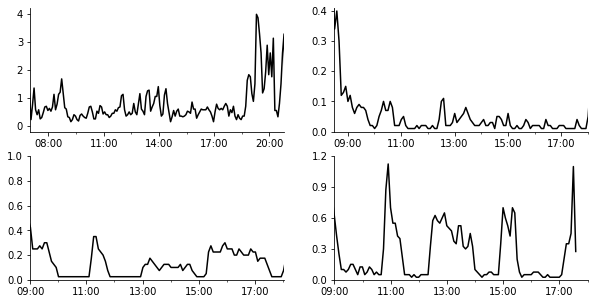

In [67]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize = (10,5))
ax2.set_ylim(-0,0.41)
ax2.set_yticks(np.arange(0,0.5,0.1))
ax3.set_ylim(0,1)
ax3.set_yticks(np.arange(0,1.01,0.2))
ax4.set_ylim(0,1.2)
ax4.set_yticks(np.arange(0,1.5,0.3))


ax1.set_xlim(pd.Timestamp('2010-12-7 07:00:00'), pd.Timestamp('2010-12-7 20:46:50'))
ax2.set_xlim(pd.Timestamp('2015-06-27 8:30:00'), pd.Timestamp('2015-06-27 18:00:10'))
ax3.set_xlim(pd.Timestamp('2017-07-11 9:00:00'), pd.Timestamp('2017-07-11 18:01:00'))
ax4.set_xlim(pd.Timestamp('2016-12-01 09:00:00'), pd.Timestamp('2016-12-01 18:01:00'))

#plot estimates
ax1.plot(Hospitaldailyestimates["t"],Hospitaldailyestimates["kappa"],"k-")
ax2.plot(Workplacedailyestimates["t"],Workplacedailyestimates["kappa"],"k-")
ax3.plot(IC17dailyestimates["t"],IC17dailyestimates["kappa"],"k-")
ax4.plot(WSdailyestimates["t"],WSdailyestimates["kappa"],"k-")

hourlocator1 = mdates.HourLocator(byhour=range(7,21,1)[1::3])
hourlocator2 = mdates.HourLocator(byhour=range(9,19,1)[::2])
hourlocator3 = mdates.HourLocator(byhour=range(9,21,1)[::2])
hourlocator4 = mdates.HourLocator(byhour=range(9,21,1)[::2])

majorFmt1 = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_locator(hourlocator1)
ax1.xaxis.set_major_formatter(majorFmt1)
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))

majorFmt2 = mdates.DateFormatter('%H:%M')
ax2.xaxis.set_major_locator(hourlocator2)
ax2.xaxis.set_major_formatter(majorFmt2)
ax2.xaxis.set_minor_locator(AutoMinorLocator(2))

majorFmt3 = mdates.DateFormatter('%H:%M')
ax3.xaxis.set_major_locator(hourlocator3)
ax3.xaxis.set_major_formatter(majorFmt3)
ax3.xaxis.set_minor_locator(AutoMinorLocator(2))

majorFmt4 = mdates.DateFormatter('%H:%M')
ax4.xaxis.set_major_locator(hourlocator4)
ax4.xaxis.set_major_formatter(majorFmt4)
ax4.xaxis.set_minor_locator(AutoMinorLocator(2))


ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

### Estimated population size

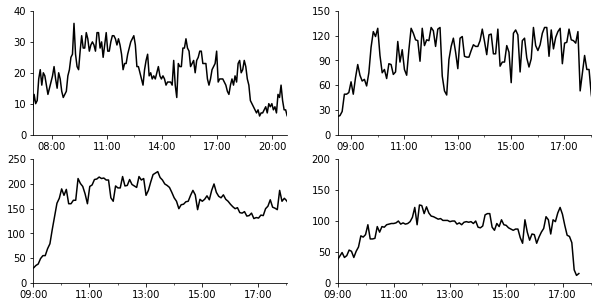

In [68]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize = (10,5))
ax1.set_ylim(-0,40)
ax1.set_yticks(np.arange(0,50,10))
ax2.set_ylim(0,150)
ax2.set_yticks(np.arange(0,180,30))

ax3.set_ylim(0,250)
ax3.set_yticks(np.arange(0,300,50))
ax4.set_ylim(0,200)
ax4.set_yticks(np.arange(0,250,50))


ax1.set_xlim(pd.Timestamp('2010-12-7 07:00:00'), pd.Timestamp('2010-12-7 20:46:50'))
ax2.set_xlim(pd.Timestamp('2015-06-27 8:30:00'), pd.Timestamp('2015-06-27 18:00:10'))
ax3.set_xlim(pd.Timestamp('2017-07-11 9:00:00'), pd.Timestamp('2017-07-11 18:01:00'))
ax4.set_xlim(pd.Timestamp('2016-12-01 09:00:00'), pd.Timestamp('2016-12-01 18:01:00'))

#plot estimates
ax1.plot(Hospitaldailyestimates["t"],Hospitaldailyestimates["np"],"k-")
ax2.plot(Workplacedailyestimates["t"],Workplacedailyestimates["np"],"k-")
ax3.plot(IC17dailyestimates["t"],IC17dailyestimates["np"],"k-")
ax4.plot(WSdailyestimates["t"],WSdailyestimates["np"],"k-")

hourlocator1 = mdates.HourLocator(byhour=range(7,21,1)[1::3])
hourlocator2 = mdates.HourLocator(byhour=range(9,19,1)[::2])
hourlocator3 = mdates.HourLocator(byhour=range(9,21,1)[::2])
hourlocator4 = mdates.HourLocator(byhour=range(9,21,1)[::2])

majorFmt1 = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_locator(hourlocator1)
ax1.xaxis.set_major_formatter(majorFmt1)
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))

majorFmt2 = mdates.DateFormatter('%H:%M')
ax2.xaxis.set_major_locator(hourlocator2)
ax2.xaxis.set_major_formatter(majorFmt2)
ax2.xaxis.set_minor_locator(AutoMinorLocator(2))

majorFmt3 = mdates.DateFormatter('%H:%M')
ax3.xaxis.set_major_locator(hourlocator3)
ax3.xaxis.set_major_formatter(majorFmt3)
ax3.xaxis.set_minor_locator(AutoMinorLocator(2))

majorFmt4 = mdates.DateFormatter('%H:%M')
ax4.xaxis.set_major_locator(hourlocator4)
ax4.xaxis.set_major_formatter(majorFmt4)
ax4.xaxis.set_minor_locator(AutoMinorLocator(2))


ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)